In [ ]:
# !pip install scikit-learn scipy matplotlib
import glob

import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from typing import Dict, List, Tuple
from scipy.stats import norm
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error


# Set working directory 
os.chdir("C:\\Users\\yonas\\Documents\\ICPAC\\ea_seasonal_pred\\seasonal-ml-pred")

PROCESSED_DIR = "data/processed"
REPORT_FIGS   = "reports/figures"
REPORT_TBLS   = "reports/tables"
os.makedirs(PROCESSED_DIR, exist_ok=True)
os.makedirs(REPORT_FIGS, exist_ok=True)
os.makedirs(REPORT_TBLS, exist_ok=True)

CLIM_BASE = (1991, 2020)
RANDOM_STATE = 42


In [7]:
PROCESSED_DIR

'data/processed'

## Load modeling tables & define feature sets

In [7]:
def load_table(fname: str):
    p = os.path.join(PROCESSED_DIR, f"{fname}.parquet")
    if os.path.exists(p):
        df = pd.read_parquet(p)
    else:
        df = pd.read_csv(os.path.join(PROCESSED_DIR, f"{fname}.csv"), index_col=0)
    # season_year index as int
    if isinstance(df.index, pd.DatetimeIndex):
        df.index = df.index.year
    else:
        try: df.index = df.index.astype(int)
        except: df.index = pd.to_datetime(df.index, errors="coerce").year
    df.index.name = "season_year"
    return df.sort_index()

OND_tab = load_table("uganda_OND_target_features_1981_2024")
# MAM_tab = load_table("model_table_MAM")

In [8]:
OND_target_cols = ["OND_total_mm","OND_clim1991_2020_mm","OND_anom_mm","OND_anom_std"]
#MAM_target_cols = ["MAM_total_mm","MAM_clim1991_2020_mm","MAM_anom_mm","MAM_anom_std"]
OND_target_cols

['OND_total_mm', 'OND_clim1991_2020_mm', 'OND_anom_mm', 'OND_anom_std']

In [9]:
OND_X = [c for c in OND_tab.columns if c not in OND_target_cols]
#MAM_X = [c for c in MAM_tab.columns if c not in MAM_target_cols]
OND_X

['n12_JAS',
 'n12_AS',
 'n12_Sep',
 'n3_JAS',
 'n3_AS',
 'n3_Sep',
 'n34_JAS',
 'n34_AS',
 'n34_Sep',
 'n4_JAS',
 'n4_AS',
 'n4_Sep',
 'meiv2_JAS',
 'meiv2_AS',
 'meiv2_Sep',
 'oni_JAS',
 'oni_AS',
 'oni_Sep',
 'pacwarmpool_JAS',
 'pacwarmpool_AS',
 'pacwarmpool_Sep',
 'censo_JAS',
 'censo_AS',
 'censo_Sep',
 'dmi_JAS',
 'dmi_AS',
 'dmi_Sep',
 'PERSIST_MJJ_anom_mm',
 'PERSIST_JJA_anom_mm',
 'PERSIST_JAS_anom_mm']

In [10]:
print("OND:", OND_tab.shape, "features:", len(OND_X))
#print("MAM:", MAM_tab.shape, "features:", len(MAM_X))


OND: (44, 34) features: 30


## Utilities (terciles, metrics, probabilities, reliability)

In [11]:
def tercile_thresholds(series: pd.Series, base=CLIM_BASE) -> Tuple[float,float]:
    mask = (series.index >= base[0]) & (series.index <= base[1])
    base_vals = series[mask].dropna()
    return float(base_vals.quantile(1/3)), float(base_vals.quantile(2/3))

def metrics_det(y_true, y_pred):
    # ensure 1D float arrays and drop NaNs/Infs
    y_true = np.asarray(y_true, dtype=float).ravel()
    y_pred = np.asarray(y_pred, dtype=float).ravel()
    m = np.isfinite(y_true) & np.isfinite(y_pred)
    y_true = y_true[m]
    y_pred = y_pred[m]
    if y_true.size == 0:
        return {"r": np.nan, "MAE": np.nan, "RMSE": np.nan,
                "MSESS_vs_clim": np.nan, "Bias": np.nan}

    # correlation (guard against zero variance)
    if y_true.size > 1 and np.std(y_true) > 0 and np.std(y_pred) > 0:
        r = float(np.corrcoef(y_true, y_pred)[0, 1])
    else:
        r = np.nan

    mae = mean_absolute_error(y_true, y_pred)

    # Always compute RMSE compatibly (sqrt of MSE)
    mse  = mean_squared_error(y_true, y_pred)            # default squared=True in all versions
    rmse = float(np.sqrt(mse))

    mse_clim = mean_squared_error(y_true, np.zeros_like(y_true))
    msess = float(1 - (mse / mse_clim)) if mse_clim > 0 else np.nan

    bias = float(np.mean(y_pred - y_true))
    return {"r": r, "MAE": mae, "RMSE": rmse, "MSESS_vs_clim": msess, "Bias": bias}

def normal_tercile_probs(mu: float, sigma: float, q33: float, q67: float) -> Tuple[float,float,float]:
    if not np.isfinite(sigma) or sigma <= 1e-8:
        # degenerate
        if   mu < q33: return 1.0, 0.0, 0.0
        elif mu > q67: return 0.0, 0.0, 1.0
        else:          return 0.0, 1.0, 0.0
    p_below = norm.cdf(q33, loc=mu, scale=sigma)
    p_above = 1 - norm.cdf(q67, loc=mu, scale=sigma)
    p_near  = 1 - p_below - p_above
    # numerical guard
    p_near = max(0.0, min(1.0, p_near))
    return float(p_below), float(p_near), float(p_above)

def reliability_curve(p: np.ndarray, y_event: np.ndarray, nbins: int = 10):
    """Return bin_centers, obs_freq, counts for reliability diagram."""
    p = np.asarray(p); y = np.asarray(y_event).astype(int)
    mask = np.isfinite(p) & np.isfinite(y)
    p = p[mask]; y = y[mask]
    if len(p) < 3: 
        return np.array([]), np.array([]), np.array([])
    bins = np.linspace(0,1,nbins+1)
    inds = np.digitize(p, bins) - 1
    obs = []; cnt = []; cen = []
    for b in range(nbins):
        m = inds == b
        if m.sum() > 0:
            cen.append(0.5*(bins[b]+bins[b+1]))
            cnt.append(m.sum())
            obs.append(y[m].mean())
    return np.array(cen), np.array(obs), np.array(cnt)

def plot_reliability(p, y_event, title, outfile):
    x, y, n = reliability_curve(p, y_event, nbins=10)
    if len(x)==0:
        print("Not enough data for reliability.")
        return
    fig, ax = plt.subplots(figsize=(5,5))
    ax.plot([0,1],[0,1], "--", color="gray", lw=1, label="Perfect")
    ax.plot(x, y, marker="o")
    ax.set_title(title); ax.set_xlabel("Forecast probability"); ax.set_ylabel("Observed frequency")
    ax.grid(alpha=0.3)
    fig.tight_layout(); fig.savefig(outfile, dpi=150); plt.show()


## Model pipelines

In [12]:
def make_model_and_grid(kind: str):
    if kind == "ols":
        pipe = Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
            ("mdl", LinearRegression())
        ])
        grid = {}  # no hyperparams
    elif kind == "ridge":
        pipe = Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
            ("mdl", Ridge(random_state=RANDOM_STATE, max_iter=10000))
        ])
        grid = {"mdl__alpha": np.logspace(-4, 2, 15)}
    elif kind == "lasso":
        pipe = Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
            ("mdl", Lasso(random_state=RANDOM_STATE, max_iter=20000))
        ])
        grid = {"mdl__alpha": np.logspace(-4, 1, 15)}
    elif kind == "enet":
        pipe = Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
            ("mdl", ElasticNet(random_state=RANDOM_STATE, max_iter=20000))
        ])
        grid = {"mdl__alpha": np.logspace(-4, 1, 12), "mdl__l1_ratio": [0.1,0.3,0.5,0.7,0.9]}
    else:
        raise ValueError("kind must be one of: 'ols','ridge','lasso','enet'")
    return pipe, grid


## Data Splits [Fixed 70/15/15] and Evaluation

In [13]:
def fixed_splits_eval(table: pd.DataFrame, season: str, xcols: List[str], anomaly_col: str, clim_col: str,
                      years=(1981,2010,2017,2024), models=("ols","ridge","lasso","enet")):
    """
    years=(train_start, train_end, val_end, test_end)
    train = [start..train_end], val = [train_end+1..val_end], test = [val_end+1..test_end]
    """
    y0, tr_end, va_end, te_end = years
    # rows present
    years_all = table.index.values
    train_idx = [y for y in years_all if y0 <= y <= tr_end]
    val_idx   = [y for y in years_all if tr_end < y <= va_end]
    test_idx  = [y for y in years_all if va_end  < y <= te_end]

    # terciles from whole series (1991–2020)
    q33, q67 = tercile_thresholds(table[anomaly_col])

    res_all = []
    for kind in models:
        pipe, grid = make_model_and_grid(kind)

        # inner CV on TRAIN only
        X_tr = table.loc[train_idx, xcols].values
        y_tr = table.loc[train_idx, anomaly_col].values
        tss = TimeSeriesSplit(n_splits=min(5, max(2, len(train_idx)//5)))
        gscv = GridSearchCV(pipe, param_grid=grid, cv=tss, scoring="neg_mean_squared_error", refit=True)
        gscv.fit(X_tr, y_tr)

        # sigma from TRAIN residuals of best model
        y_tr_hat = gscv.predict(X_tr)
        sigma_tr = float(np.std(y_tr - y_tr_hat, ddof=1))

        def _predict(idx):
            X = table.loc[idx, xcols].values
            yh = gscv.predict(X)
            clim = table.loc[idx, clim_col].values
            tot = yh + clim
            # tercile probs from Normal(mu=yh, sigma=sigma_tr)
            p_b, p_n, p_a = [], [], []
            for mu in yh:
                b,n,a = normal_tercile_probs(mu, sigma_tr, q33, q67)
                p_b.append(b); p_n.append(n); p_a.append(a)
            return pd.DataFrame({
                "season_year": idx,
                "y_pred_anom_mm": yh,
                "y_pred_total_mm": tot,
                "p_below": p_b, "p_near": p_n, "p_above": p_a
            }).set_index("season_year")

        # predictions
        pred_tr = _predict(train_idx)
        pred_va = _predict(val_idx)
        pred_te = _predict(test_idx)

        # assemble with obs
        def attach_obs(df_pred, idx):
            out = df_pred.copy()
            out["y_obs_anom_mm"]  = table.loc[idx, anomaly_col].values
            out["y_obs_total_mm"] = table.loc[idx, clim_col].values + out["y_obs_anom_mm"].values
            return out

        tr = attach_obs(pred_tr, train_idx)
        va = attach_obs(pred_va, val_idx)
        te = attach_obs(pred_te, test_idx)

        # metrics
        det_tr = metrics_det(tr["y_obs_anom_mm"], tr["y_pred_anom_mm"])
        det_va = metrics_det(va["y_obs_anom_mm"], va["y_pred_anom_mm"])
        det_te = metrics_det(te["y_obs_anom_mm"], te["y_pred_anom_mm"])

        res_all.append((kind, gscv.best_params_, sigma_tr, det_tr, det_va, det_te))

        # save predictions
        base = f"{season}_{kind}_split_pred"
        tr.to_csv(os.path.join(PROCESSED_DIR, f"{base}_train.csv"))
        va.to_csv(os.path.join(PROCESSED_DIR, f"{base}_val.csv"))
        te.to_csv(os.path.join(PROCESSED_DIR, f"{base}_test.csv"))

        # reliability on test (above/below)
        y_cls_te = pd.Series(np.where(te["y_obs_anom_mm"] > q67, 1, np.where(te["y_obs_anom_mm"] < q33, -1, 0)), index=te.index)
        plot_reliability(te["p_above"].values, (y_cls_te==1).values.astype(int),
                         f"{season} {kind} – Reliability (Above normal, TEST)",
                         os.path.join(REPORT_FIGS, f"{season}_{kind}_reliability_above_TEST.png"))
        plot_reliability(te["p_below"].values, (y_cls_te==-1).values.astype(int),
                         f"{season} {kind} – Reliability (Below normal, TEST)",
                         os.path.join(REPORT_FIGS, f"{season}_{kind}_reliability_below_TEST.png"))

        # residuals by decade (test)
        te["resid_mm"] = te["y_obs_anom_mm"] - te["y_pred_anom_mm"]
        d = (pd.DataFrame({"resid": te["resid_mm"]})
             .assign(decade=lambda x: (pd.Index(x.index).astype(int)//10)*10)
             .groupby("decade")["resid"].agg(["mean","std","count"]))
        d.to_csv(os.path.join(REPORT_TBLS, f"{season}_{kind}_residuals_by_decade_TEST.csv"))

    # summary table
    rows = []
    for kind, bp, sig, trm, vam, tem in res_all:
        rows.append({"model": kind, **{f"tr_{k}":v for k,v in trm.items()},
                               **{f"va_{k}":v for k,v in vam.items()},
                               **{f"te_{k}":v for k,v in tem.items()},
                               "sigma_train": sig, "best_params": bp})
    summary = pd.DataFrame(rows).set_index("model")
    summary.to_csv(os.path.join(REPORT_TBLS, f"{season}_fixedsplit_metrics.csv"))
    return summary


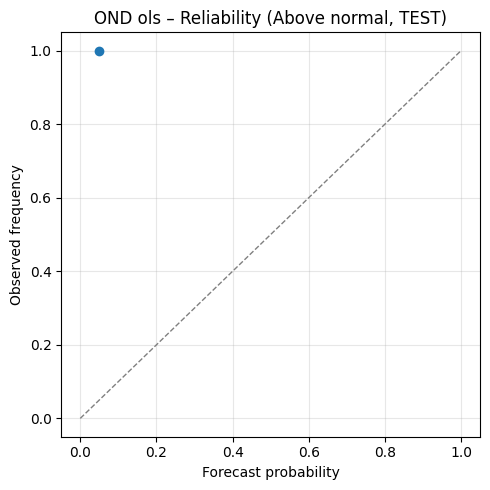

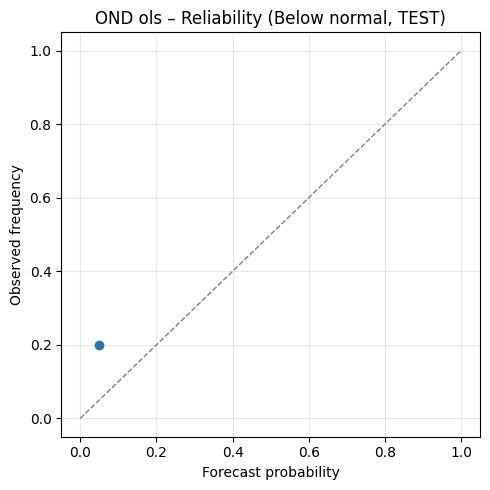

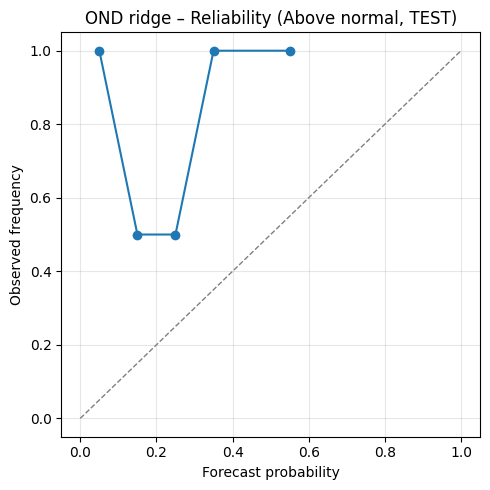

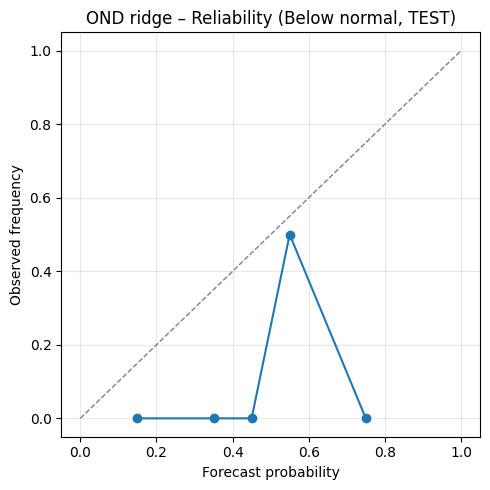

c:\Users\yonas\Documents\ICPAC\ea_seasonal_pred\seasonal_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.245e+00, tolerance: 2.567e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\yonas\Documents\ICPAC\ea_seasonal_pred\seasonal_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.063e+00, tolerance: 5.466e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\yonas\Documents\ICPAC\ea_seasonal_pred\seasonal_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterati

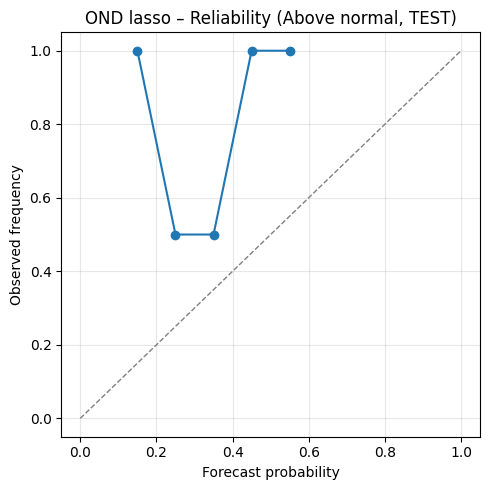

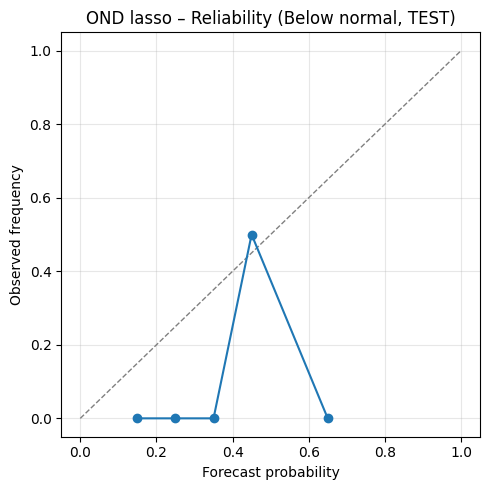

c:\Users\yonas\Documents\ICPAC\ea_seasonal_pred\seasonal_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.376e+00, tolerance: 2.067e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\yonas\Documents\ICPAC\ea_seasonal_pred\seasonal_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.202e+02, tolerance: 2.567e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\yonas\Documents\ICPAC\ea_seasonal_pred\seasonal_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterati

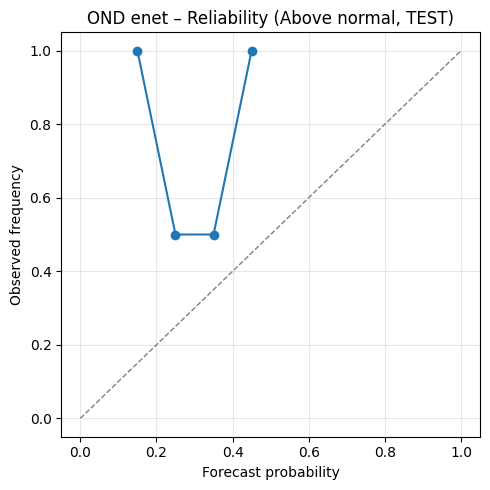

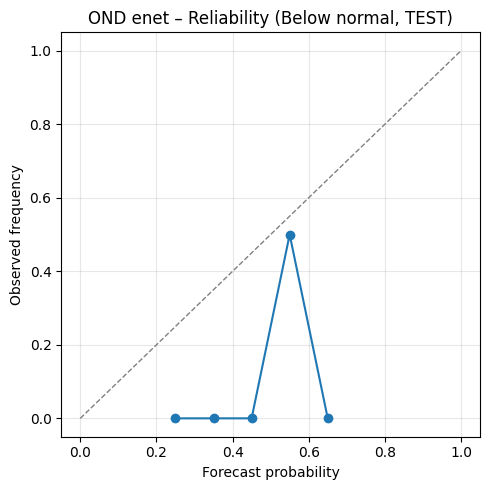

,tr_r,tr_MAE,tr_RMSE,tr_MSESS_vs_clim,tr_Bias,va_r,va_MAE,va_RMSE,va_MSESS_vs_clim,va_Bias,te_r,te_MAE,te_RMSE,te_MSESS_vs_clim,te_Bias,sigma_train,best_params
model,,,,,,,,,,,,,,,,,
ols,1.000000,2.030628e-12,2.717380e-12,1.000000,4.415727e-14,-0.271100,257.629365,328.716383,-21.254015,-216.896566,-0.233901,239.436121,261.748179,-7.574325,19.251928,2.763469e-12,{}
ridge,0.508066,3.933139e+01,4.758609e+01,0.339794,3.552714e-15,0.817224,53.381299,65.722103,0.110413,-34.637046,0.323365,78.529928,100.689930,-0.268834,-70.711663,4.839959e+01,{'mdl__alpha': 100.0}
lasso,0.580779,3.787217e+01,4.703375e+01,0.355031,5.447494e-15,0.832918,55.601844,69.032571,0.018537,-32.151212,0.430264,74.096006,92.063535,-0.060737,-60.251987,4.783781e+01,{'mdl__alpha': 10.0}
enet,0.474145,3.998338e+01,4.921026e+01,0.293958,3.789561e-15,0.754151,54.819723,67.980391,0.048228,-34.538469,0.287542,78.759173,101.317182,-0.284691,-70.575905,5.005152e+01,"{'mdl__alpha': 10.0, 'mdl__l1_ratio': 0.1}"


In [21]:
OND_fixed = fixed_splits_eval(
    OND_tab, "OND", OND_X, "OND_anom_mm", "OND_clim1991_2020_mm",
    years=(1981, 2010, 2017, 2024),
    models=("ols","ridge","lasso","enet")
)
OND_fixed


## Rolling-origin hindcast (1981–2024) for each model

In [18]:
def hindcast_regression(table: pd.DataFrame, season: str, xcols: List[str], anomaly_col: str, clim_col: str,
                        models=("ols","ridge","lasso","enet"), min_train: int = 10):
    # fixed terciles from 1991–2020
    q33, q67 = tercile_thresholds(table[anomaly_col])
    years = table.index.values
    results = {}

    for kind in models:
        pipe, grid = make_model_and_grid(kind)
        preds = []

        for i in range(len(years)):
            y = int(years[i])
            tr_years = years[:i]
            if len(tr_years) < min_train:
                continue

            train = table.loc[tr_years]
            test  = table.loc[[y]]

            X_tr = train[xcols].values
            y_tr = train[anomaly_col].values
            X_te = test[xcols].values

            # inner CV on training
            tss = TimeSeriesSplit(n_splits=min(5, max(2, len(tr_years)//5)))
            gscv = GridSearchCV(pipe, param_grid=grid, cv=tss, scoring="neg_mean_squared_error", refit=True)
            gscv.fit(X_tr, y_tr)

            # sigma from training residuals
            y_tr_hat = gscv.predict(X_tr)
            sigma_tr = float(np.std(y_tr - y_tr_hat, ddof=1))

            # predict year y
            mu = float(gscv.predict(X_te)[0])
            clim_val = float(test[clim_col].iloc[0])

            p_b, p_n, p_a = normal_tercile_probs(mu, sigma_tr, q33, q67)

            preds.append({
                "season_year": y,
                "y_obs_anom_mm": float(test[anomaly_col].iloc[0]),
                "y_pred_anom_mm": mu,
                "y_obs_total_mm": float(test[anomaly_col].iloc[0] + clim_val),
                "y_pred_total_mm": float(mu + clim_val),
                "p_below": p_b, "p_near": p_n, "p_above": p_a,
                "sigma_train": sigma_tr
            })

        hc = pd.DataFrame(preds).set_index("season_year")
        # metrics
        det = metrics_det(hc["y_obs_anom_mm"], hc["y_pred_anom_mm"])

        # save
        out_csv = os.path.join(PROCESSED_DIR, f"hindcast_{season}_{kind}.csv")
        hc.to_csv(out_csv)

        # reliability
        y_cls = pd.Series(np.where(hc["y_obs_anom_mm"] > q67, 1, np.where(hc["y_obs_anom_mm"] < q33, -1, 0)), index=hc.index)
        plot_reliability(hc["p_above"].values, (y_cls==1).values.astype(int),
                         f"{season} {kind} – Reliability (Above normal, HINDCAST)",
                         os.path.join(REPORT_FIGS, f"{season}_{kind}_reliability_above_HC.png"))
        plot_reliability(hc["p_below"].values, (y_cls==-1).values.astype(int),
                         f"{season} {kind} – Reliability (Below normal, HINDCAST)",
                         os.path.join(REPORT_FIGS, f"{season}_{kind}_reliability_below_HC.png"))

        # residuals by decade
        hc["resid_mm"] = hc["y_obs_anom_mm"] - hc["y_pred_anom_mm"]
        d = (pd.DataFrame({"resid": hc["resid_mm"]})
             .assign(decade=lambda x: (pd.Index(x.index).astype(int)//10)*10)
             .groupby("decade")["resid"].agg(["mean","std","count"]))
        d.to_csv(os.path.join(REPORT_TBLS, f"{season}_{kind}_residuals_by_decade_HC.csv"))

        results[kind] = {"hindcast": hc, "metrics": det}

    # write a summary
    rows = []
    for k,v in results.items():
        rows.append({"model": k, **v["metrics"]})
    summary = pd.DataFrame(rows).set_index("model")
    summary.to_csv(os.path.join(REPORT_TBLS, f"{season}_hindcast_metrics.csv"))
    return results, summary


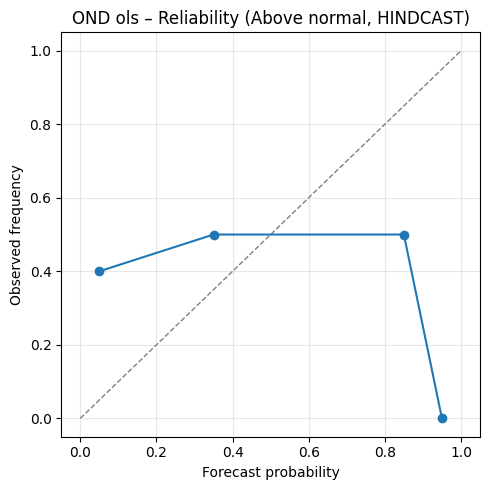

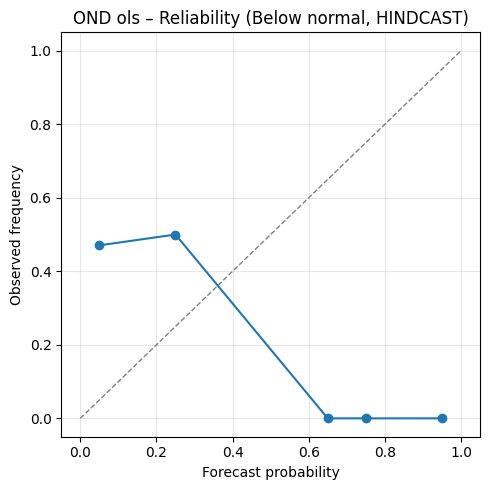

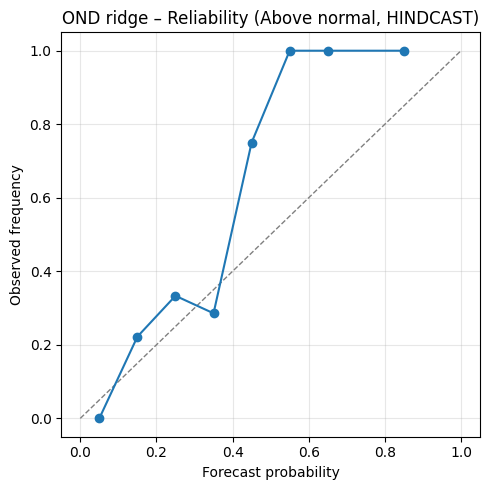

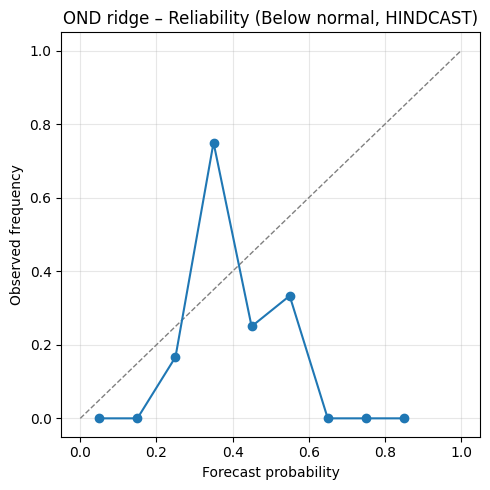

c:\Users\yonas\Documents\ICPAC\ea_seasonal_pred\seasonal_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.993e+00, tolerance: 2.067e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\yonas\Documents\ICPAC\ea_seasonal_pred\seasonal_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.073e+00, tolerance: 2.067e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\yonas\Documents\ICPAC\ea_seasonal_pred\seasonal_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterati

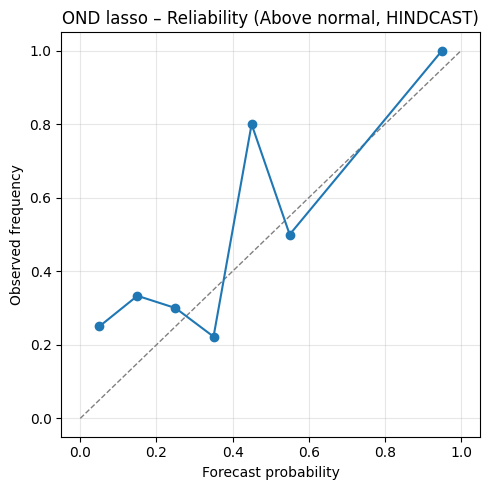

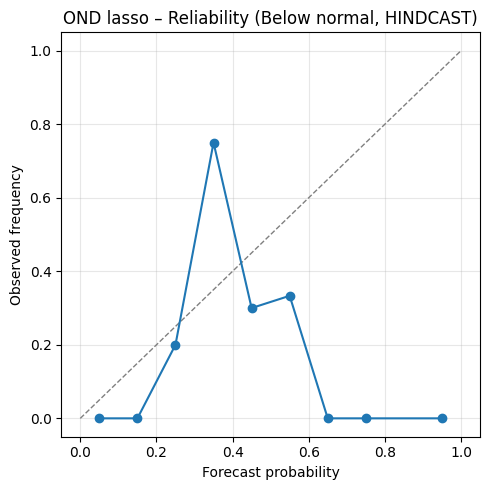

c:\Users\yonas\Documents\ICPAC\ea_seasonal_pred\seasonal_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.481e+00, tolerance: 9.760e-01
  model = cd_fast.enet_coordinate_descent(
c:\Users\yonas\Documents\ICPAC\ea_seasonal_pred\seasonal_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.934e+00, tolerance: 9.760e-01
  model = cd_fast.enet_coordinate_descent(
c:\Users\yonas\Documents\ICPAC\ea_seasonal_pred\seasonal_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterati

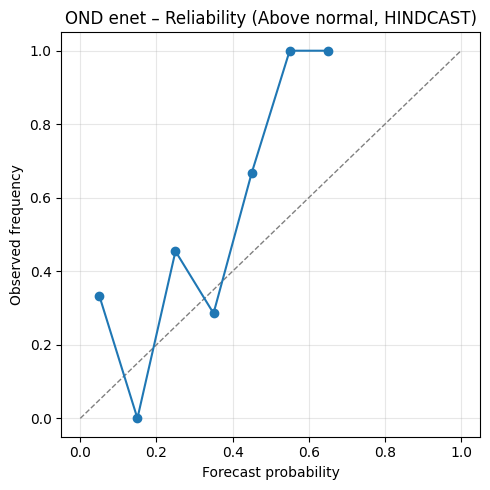

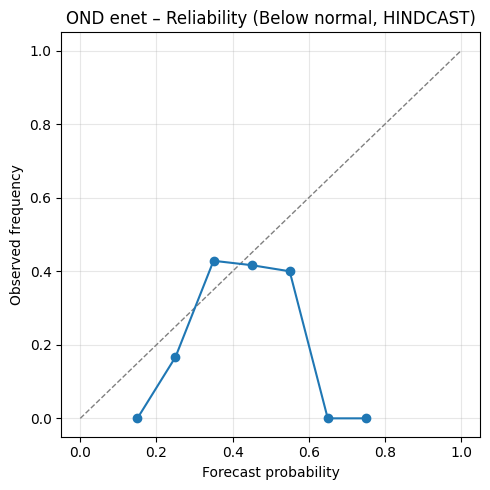

,r,MAE,RMSE,MSESS_vs_clim,Bias
model,,,,,
ols,-0.082763,185.119630,251.367753,-12.000392,-8.217592
ridge,0.348874,53.088238,68.011407,0.048298,-18.962839
lasso,0.187764,58.195776,73.357076,-0.107188,-20.155728
enet,0.194140,57.601899,74.666248,-0.147060,-23.805878


In [23]:
OND_hc, OND_hc_summary = hindcast_regression(OND_tab, "OND", OND_X, "OND_anom_mm", "OND_clim1991_2020_mm",
                                             models=("ols","ridge","lasso","enet"))


OND_hc_summary


## Present percent anomalies & export “final” tables

In [26]:
def add_percent_anomaly(df: pd.DataFrame, clim_series: pd.Series) -> pd.DataFrame:
    # clim_series should be indexed by season_year
    out = df.copy()
    c = clim_series.reindex(out.index).astype(float)
    out["y_obs_pct"]  = 100.0 * (out["y_obs_total_mm"]  - c) / c
    out["y_pred_pct"] = 100.0 * (out["y_pred_total_mm"] - c) / c
    return out

# Add to hindcasts and rewrite
OND_clim = OND_tab["OND_clim1991_2020_mm"]
#MAM_clim = MAM_tab["MAM_clim1991_2020_mm"]

for model, bundle in OND_hc.items():
    hc = add_percent_anomaly(bundle["hindcast"], OND_clim)
    hc.to_csv(os.path.join(PROCESSED_DIR, f"hindcast_OND_{model}_with_percent.csv"))

# for model, bundle in MAM_hc.items():
#     hc = add_percent_anomaly(bundle["hindcast"], MAM_clim)
#     hc.to_csv(os.path.join(PROCESSED_DIR, f"hindcast_MAM_{model}_with_percent.csv"))


## Regime-conditioned skill (ENSO × IOD)

In [28]:
# --- Robust column picker (case-insensitive) ---
def _pick_feature(table: pd.DataFrame, base: str, suffixes: list[str]) -> pd.Series:
    """
    Find a column like f"{base}_{suffix}" ignoring case. Try suffixes in order.
    Fallback: any column containing base (case-insensitive). Raises if none found.
    """
    cols = list(table.columns)
    lower_map = {c.lower(): c for c in cols}
    for suf in suffixes:
        key = f"{base}_{suf}".lower()
        if key in lower_map:
            return table[lower_map[key]]
    # fallback: any column containing base
    candidates = [c for c in cols if base.lower() in c.lower()]
    if candidates:
        return table[candidates[0]]
    raise KeyError(f"No feature found for base='{base}' with suffixes {suffixes}. "
                   f"Available columns sample: {cols[:10]}")

def regime_mask(season: str, table: pd.DataFrame, thr_n34: float = 0.7, thr_dmi: float = 0.5, verbose: bool = True):
    """
    Build categorical ENSO/IOD regimes for the given season using lead-safe features.
    Returns two Series (enso, iod) indexed by season_year.
    """
    if season.upper() == "OND":
        # use months available by end-Sep
        n34_ser = _pick_feature(table, "n34", ["jas","as","sep"])
        dmi_ser = _pick_feature(table, "dmi", ["jas","as","sep"])
    else:
        # use months available by end-Feb (for MAM)
        n34_ser = _pick_feature(table, "n34", ["ndj","dj","feb"])
        dmi_ser = _pick_feature(table, "dmi", ["ndj","dj","feb"])

    if verbose:
        print(f"[{season}] ENSO from column: {n34_ser.name} | IOD from column: {dmi_ser.name}")

    def cat(s: pd.Series, thr_pos: float, thr_neg: float | None = None) -> pd.Series:
        if thr_neg is None: thr_neg = -thr_pos
        out = pd.Series(index=s.index, dtype="object")
        out[s >=  thr_pos] = "pos"
        out[s <=  thr_neg] = "neg"
        out[(s < thr_pos) & (s > thr_neg)] = "neu"
        return out

    enso = cat(n34_ser.astype(float), thr_n34)
    iod  = cat(dmi_ser.astype(float),  thr_dmi)
    enso.name, iod.name = "enso", "iod"
    return enso, iod

def regime_skill(hc_df: pd.DataFrame, season: str, table: pd.DataFrame, out_prefix: str,
                 min_count: int = 5) -> pd.DataFrame:
    """
    Join hindcast with ENSO/IOD regimes and compute deterministic metrics per (ENSO x IOD) cell.
    Saves CSV and returns the table.
    """
    enso, iod = regime_mask(season, table, verbose=True)

    # Align regimes to hindcast years
    enso = enso.reindex(hc_df.index)
    iod  = iod.reindex(hc_df.index)

    df = hc_df.join(enso).join(iod)

    rows = []
    for e in ["pos","neu","neg"]:
        for i in ["pos","neu","neg"]:
            m = (df["enso"] == e) & (df["iod"] == i)
            if int(m.sum()) >= min_count:
                det = metrics_det(df.loc[m, "y_obs_anom_mm"], df.loc[m, "y_pred_anom_mm"])
                rows.append({"ENSO": e, "IOD": i, "N": int(m.sum()), **det})

    out = pd.DataFrame(rows)
    out_path = os.path.join(REPORT_TBLS, f"{out_prefix}_regime_skill.csv")
    out.to_csv(out_path, index=False)
    print(f"Wrote {out_path} | rows={len(out)}")
    return out


In [29]:
for model, bundle in OND_hc.items():
    regime_skill(bundle["hindcast"], "OND", OND_tab, out_prefix=f"OND_{model}")


[OND] ENSO from column: n34_JAS | IOD from column: dmi_JAS
Wrote reports/tables\OND_ols_regime_skill.csv | rows=2
[OND] ENSO from column: n34_JAS | IOD from column: dmi_JAS
Wrote reports/tables\OND_ridge_regime_skill.csv | rows=2
[OND] ENSO from column: n34_JAS | IOD from column: dmi_JAS
Wrote reports/tables\OND_lasso_regime_skill.csv | rows=2
[OND] ENSO from column: n34_JAS | IOD from column: dmi_JAS
Wrote reports/tables\OND_enet_regime_skill.csv | rows=2


In [30]:
PROCESSED_DIR = "data/processed"
REPORT_FIGS   = "reports/figures"
os.makedirs(REPORT_FIGS, exist_ok=True)

def load_split_preds(season: str, model: str):
    """
    Load train/val/test CSVs written by fixed_splits_eval for a given season/model.
    Returns a dict with keys 'TRAIN','VAL','TEST' -> DataFrames indexed by season_year.
    """
    out = {}
    for split in ("train","val","test"):
        path = os.path.join(PROCESSED_DIR, f"{season}_{model}_split_pred_{split}.csv")
        if not os.path.exists(path):
            raise FileNotFoundError(f"Missing file: {path}\n"
                                    "Run fixed_splits_eval(...) first for this season/model.")
        df = pd.read_csv(path, index_col=0)
        # ensure season_year index is int
        if not np.issubdtype(df.index.dtype, np.integer):
            df.index = pd.Index(df.index).astype(int)
        df.index.name = "season_year"
        # add labels
        df["model"] = model
        df["split"] = split.upper()
        out[split.upper()] = df
    return out

# example: OND + ridge
ridge_ond = load_split_preds("OND", "ridge")
list(ridge_ond.keys()), ridge_ond["TRAIN"].head(2)


(['TRAIN', 'VAL', 'TEST'],
              y_pred_anom_mm  y_pred_total_mm   p_below    p_near   p_above  \
 season_year                                                                  
 1981             -40.209145       288.195155  0.585125  0.264381  0.150494   
 1982              18.740154       347.144454  0.157943  0.269200  0.572858   
 
              y_obs_anom_mm  y_obs_total_mm  model  split  
 season_year                                               
 1981             -77.08824       251.31606  ridge  TRAIN  
 1982              44.92929       373.33359  ridge  TRAIN  )

## Combine splits for a model & save one tidy table

In [31]:
def combine_splits(preds_dict: dict) -> pd.DataFrame:
    """Concat TRAIN/VAL/TEST into one tidy table."""
    combo = pd.concat([preds_dict[k] for k in ("TRAIN","VAL","TEST")], axis=0)
    combo = combo.sort_index()
    return combo

ridge_ond_all = combine_splits(ridge_ond)
ridge_ond_all.to_csv(os.path.join(PROCESSED_DIR, "OND_ridge_actual_vs_pred_split_all.csv"))
ridge_ond_all.tail(3)


,y_pred_anom_mm,y_pred_total_mm,p_below,p_near,p_above,y_obs_anom_mm,y_obs_total_mm,model,split
season_year,,,,,,,,,
2022,-57.660536,270.743764,0.717554,0.200921,0.081525,10.965271,339.369571,ridge,TEST
2023,19.243077,347.647377,0.155449,0.267621,0.576930,64.327760,392.732060,ridge,TEST
2024,-26.120629,302.283671,0.469683,0.301645,0.228672,45.866913,374.271213,ridge,TEST


## Load all models at once for one season

In [32]:
def load_all_models_for_season(season: str, models=("ols","ridge","lasso","enet")) -> pd.DataFrame:
    frames = []
    for m in models:
        try:
            frames.append(combine_splits(load_split_preds(season, m)))
        except FileNotFoundError as e:
            print(f"[skip] {m}: {e}")
    if not frames:
        raise RuntimeError(f"No split prediction files found for season={season}.")
    all_df = pd.concat(frames, axis=0).sort_index()
    out_path = os.path.join(PROCESSED_DIR, f"{season}_ALLMODELS_actual_vs_pred_split_all.csv")
    all_df.to_csv(out_path)
    print("WROTE", out_path)
    return all_df

OND_all_models = load_all_models_for_season("OND", models=("ols","ridge","lasso","enet"))
OND_all_models.head(2)


WROTE data/processed\OND_ALLMODELS_actual_vs_pred_split_all.csv


,y_pred_anom_mm,y_pred_total_mm,p_below,p_near,p_above,y_obs_anom_mm,y_obs_total_mm,model,split
season_year,,,,,,,,,
1981,-77.088240,251.316060,1.000000,0.000000,0.000000,-77.08824,251.31606,ols,TRAIN
1981,-40.209145,288.195155,0.585125,0.264381,0.150494,-77.08824,251.31606,ridge,TRAIN


In [33]:
#from sklearn.metrics import mean_absolute_error, mean_squared_error

def metrics_det(y_true, y_pred):
    # robust across sklearn versions; drop NaNs
    y_true = np.asarray(y_true, dtype=float).ravel()
    y_pred = np.asarray(y_pred, dtype=float).ravel()
    m = np.isfinite(y_true) & np.isfinite(y_pred)
    y_true, y_pred = y_true[m], y_pred[m]
    if y_true.size == 0:
        return {"r": np.nan, "MAE": np.nan, "RMSE": np.nan, "MSESS_vs_clim": np.nan, "Bias": np.nan}
    r = float(np.corrcoef(y_true, y_pred)[0,1]) if np.std(y_true)>0 and np.std(y_pred)>0 else np.nan
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mse_clim = mean_squared_error(y_true, np.zeros_like(y_true))
    msess = float(1 - (mse / mse_clim)) if mse_clim > 0 else np.nan
    bias = float(np.mean(y_pred - y_true))
    return {"r": r, "MAE": mae, "RMSE": rmse, "MSESS_vs_clim": msess, "Bias": bias}

def metrics_by_split(df: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for (model, split), g in df.groupby(["model","split"]):
        det = metrics_det(g["y_obs_anom_mm"], g["y_pred_anom_mm"])
        rows.append({"model": model, "split": split, **det})
    out = pd.DataFrame(rows).sort_values(["model","split"])
    return out

metrics_by_split(OND_all_models)


,model,split,r,MAE,RMSE,MSESS_vs_clim,Bias
0,enet,TEST,0.287542,7.875917e+01,1.013172e+02,-0.284691,-7.057590e+01
1,enet,TRAIN,0.474145,3.998338e+01,4.921026e+01,0.293958,3.789561e-15
2,enet,VAL,0.754151,5.481972e+01,6.798039e+01,0.048228,-3.453847e+01
3,lasso,TEST,0.430264,7.409601e+01,9.206353e+01,-0.060737,-6.025199e+01
4,lasso,TRAIN,0.580779,3.787217e+01,4.703375e+01,0.355031,3.079019e-15
5,lasso,VAL,0.832918,5.560184e+01,6.903257e+01,0.018537,-3.215121e+01
6,ols,TEST,-0.233901,2.394361e+02,2.617482e+02,-7.574325,1.925193e+01
7,ols,TRAIN,1.000000,2.030331e-12,2.717091e-12,1.000000,4.386121e-14
8,ols,VAL,-0.271100,2.576294e+02,3.287164e+02,-21.254015,-2.168966e+02
9,ridge,TEST,0.323365,7.852993e+01,1.006899e+02,-0.268834,-7.071166e+01


In [34]:
def plot_actual_vs_pred_lines(df: pd.DataFrame, season: str, model: str, save=True):
    """
    Line plots (anomaly mm and total mm) by split.
    """
    fig, axes = plt.subplots(3, 2, figsize=(14, 10), sharex=False)
    splits = ["TRAIN","VAL","TEST"]
    for i, sp in enumerate(splits):
        g = df[(df["model"]==model) & (df["split"]==sp)]
        if g.empty: continue
        g = g.sort_index()
        # left: anomalies
        ax = axes[i,0]
        ax.plot(g.index, g["y_obs_anom_mm"], label="Obs anom (mm)", linewidth=2)
        ax.plot(g.index, g["y_pred_anom_mm"], label="Pred anom (mm)")
        ax.set_title(f"{sp} — anomaly (mm)")
        ax.grid(alpha=0.3); ax.legend(loc="best")
        # right: totals
        ax = axes[i,1]
        ax.plot(g.index, g["y_obs_total_mm"], label="Obs total (mm)", linewidth=2)
        ax.plot(g.index, g["y_pred_total_mm"], label="Pred total (mm)")
        ax.set_title(f"{sp} — total (mm)")
        ax.grid(alpha=0.3); ax.legend(loc="best")
    fig.suptitle(f"{season} – {model}: Actual vs Predicted (by split)", y=1.02, fontsize=13)
    fig.tight_layout()
    if save:
        out = os.path.join(REPORT_FIGS, f"{season}_{model}_actual_vs_pred_lines.png")
        fig.savefig(out, dpi=150)
        print("Saved", out)
    plt.show()

def plot_pred_vs_obs_scatter(df: pd.DataFrame, season: str, model: str, save=True):
    """
    Scatter of predicted vs observed (anomaly mm) by split with 1:1 line.
    """
    splits = ["TRAIN","VAL","TEST"]
    fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=True)
    for i, sp in enumerate(splits):
        ax = axes[i]
        g = df[(df["model"]==model) & (df["split"]==sp)]
        if g.empty:
            ax.set_axis_off(); continue
        x = g["y_obs_anom_mm"].values
        y = g["y_pred_anom_mm"].values
        ax.scatter(x, y, s=35, alpha=0.9)
        lim = np.nanmax(np.abs(np.concatenate([x,y]))) if len(x)>0 else 1.0
        lim = max(1.0, lim)
        ax.plot([-lim, lim], [-lim, lim], "--", color="gray", lw=1)
        det = metrics_det(x, y)
        ax.set_title(f"{sp}\nr={det['r']:.2f}, RMSE={det['RMSE']:.1f}")
        ax.set_xlabel("Observed anom (mm)")
        if i==0: ax.set_ylabel("Predicted anom (mm)")
        ax.grid(alpha=0.3)
    fig.suptitle(f"{season} – {model}: Predicted vs Observed (anomaly mm)", y=1.02, fontsize=13)
    fig.tight_layout()
    if save:
        out = os.path.join(REPORT_FIGS, f"{season}_{model}_pred_vs_obs_scatter.png")
        fig.savefig(out, dpi=150)
        print("Saved", out)
    plt.show()


Saved reports/figures\OND_ridge_actual_vs_pred_lines.png


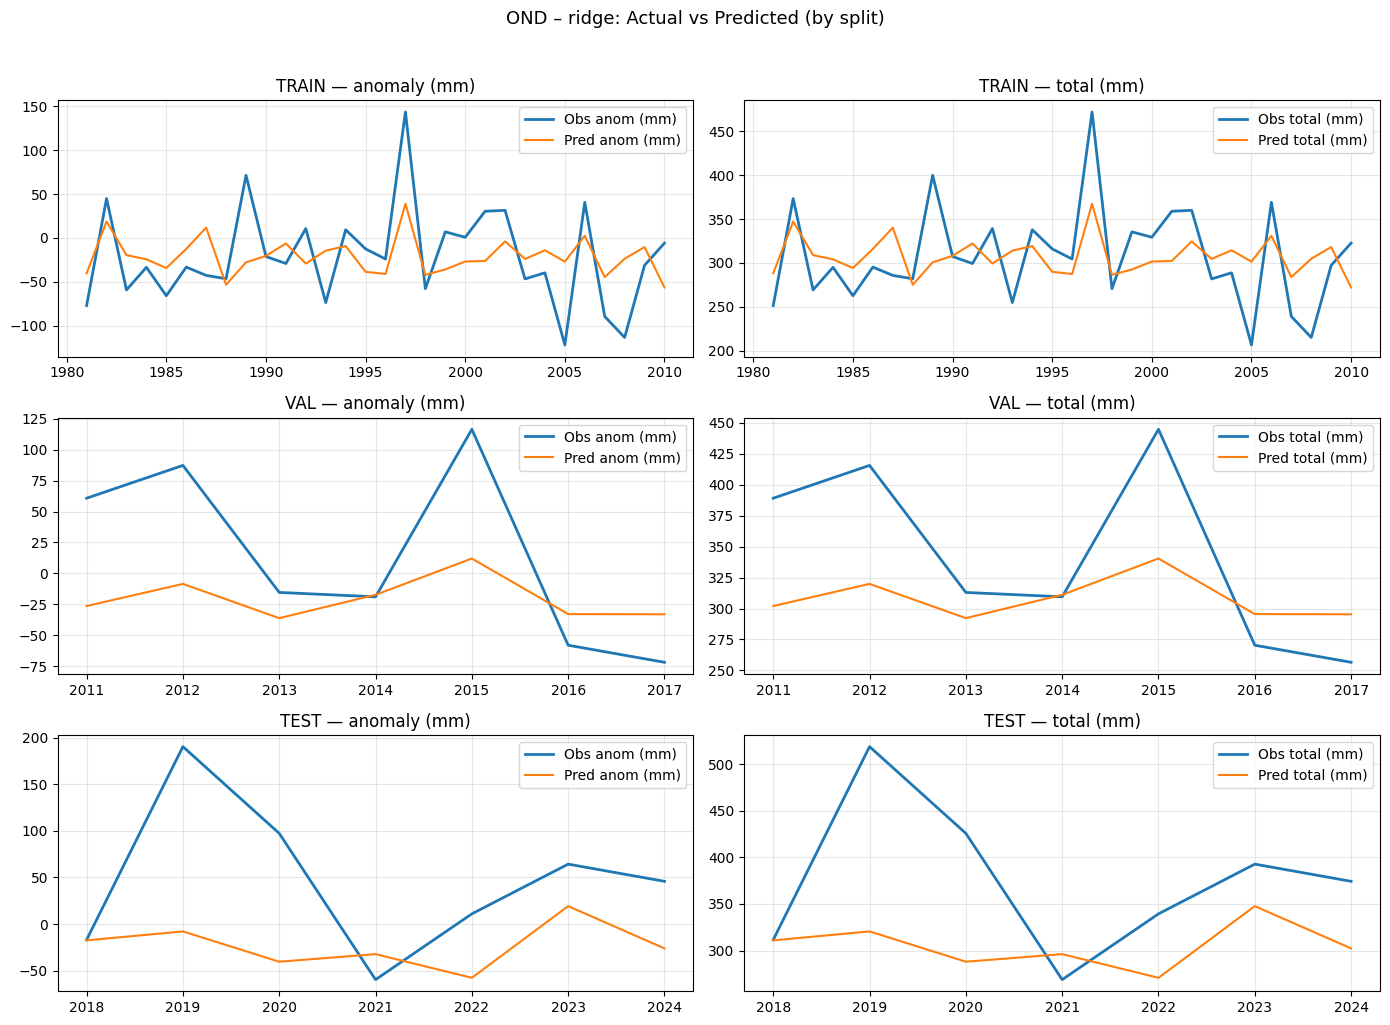

Saved reports/figures\OND_ridge_pred_vs_obs_scatter.png


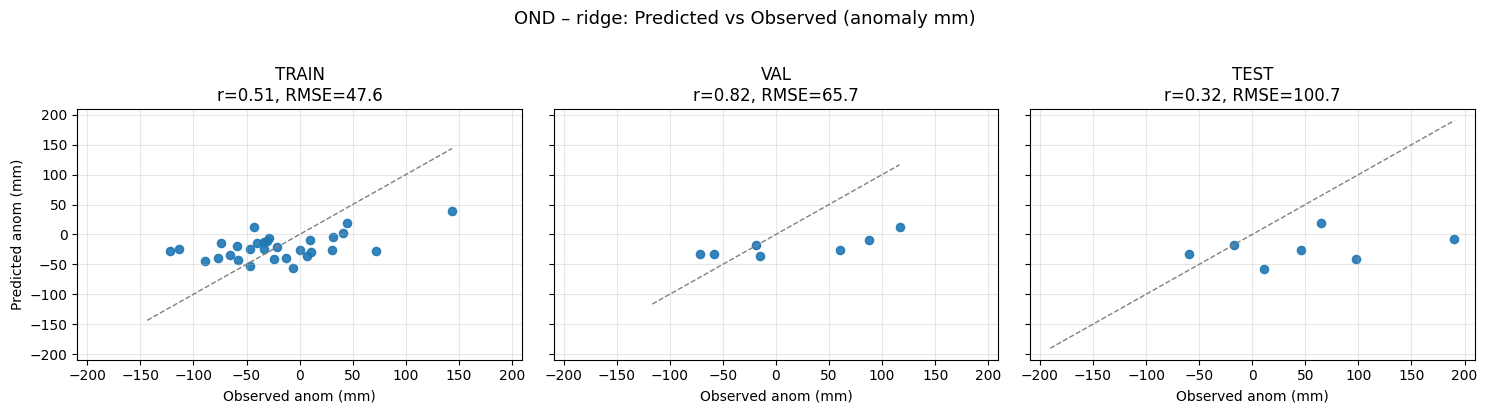

In [35]:
plot_actual_vs_pred_lines(OND_all_models, "OND", "ridge")
plot_pred_vs_obs_scatter(OND_all_models, "OND", "ridge")


In [36]:
# OND: per-model, per-split deterministic metrics
OND_split_scores = metrics_by_split(OND_all_models)
OND_split_scores.to_csv(os.path.join(PROCESSED_DIR, "OND_split_metrics_by_model.csv"), index=False)
OND_split_scores


,model,split,r,MAE,RMSE,MSESS_vs_clim,Bias
0,enet,TEST,0.287542,7.875917e+01,1.013172e+02,-0.284691,-7.057590e+01
1,enet,TRAIN,0.474145,3.998338e+01,4.921026e+01,0.293958,3.789561e-15
2,enet,VAL,0.754151,5.481972e+01,6.798039e+01,0.048228,-3.453847e+01
3,lasso,TEST,0.430264,7.409601e+01,9.206353e+01,-0.060737,-6.025199e+01
4,lasso,TRAIN,0.580779,3.787217e+01,4.703375e+01,0.355031,3.079019e-15
5,lasso,VAL,0.832918,5.560184e+01,6.903257e+01,0.018537,-3.215121e+01
6,ols,TEST,-0.233901,2.394361e+02,2.617482e+02,-7.574325,1.925193e+01
7,ols,TRAIN,1.000000,2.030331e-12,2.717091e-12,1.000000,4.386121e-14
8,ols,VAL,-0.271100,2.576294e+02,3.287164e+02,-21.254015,-2.168966e+02
9,ridge,TEST,0.323365,7.852993e+01,1.006899e+02,-0.268834,-7.071166e+01


### OLS

Saved reports/figures\OND_ols_actual_vs_pred_lines.png


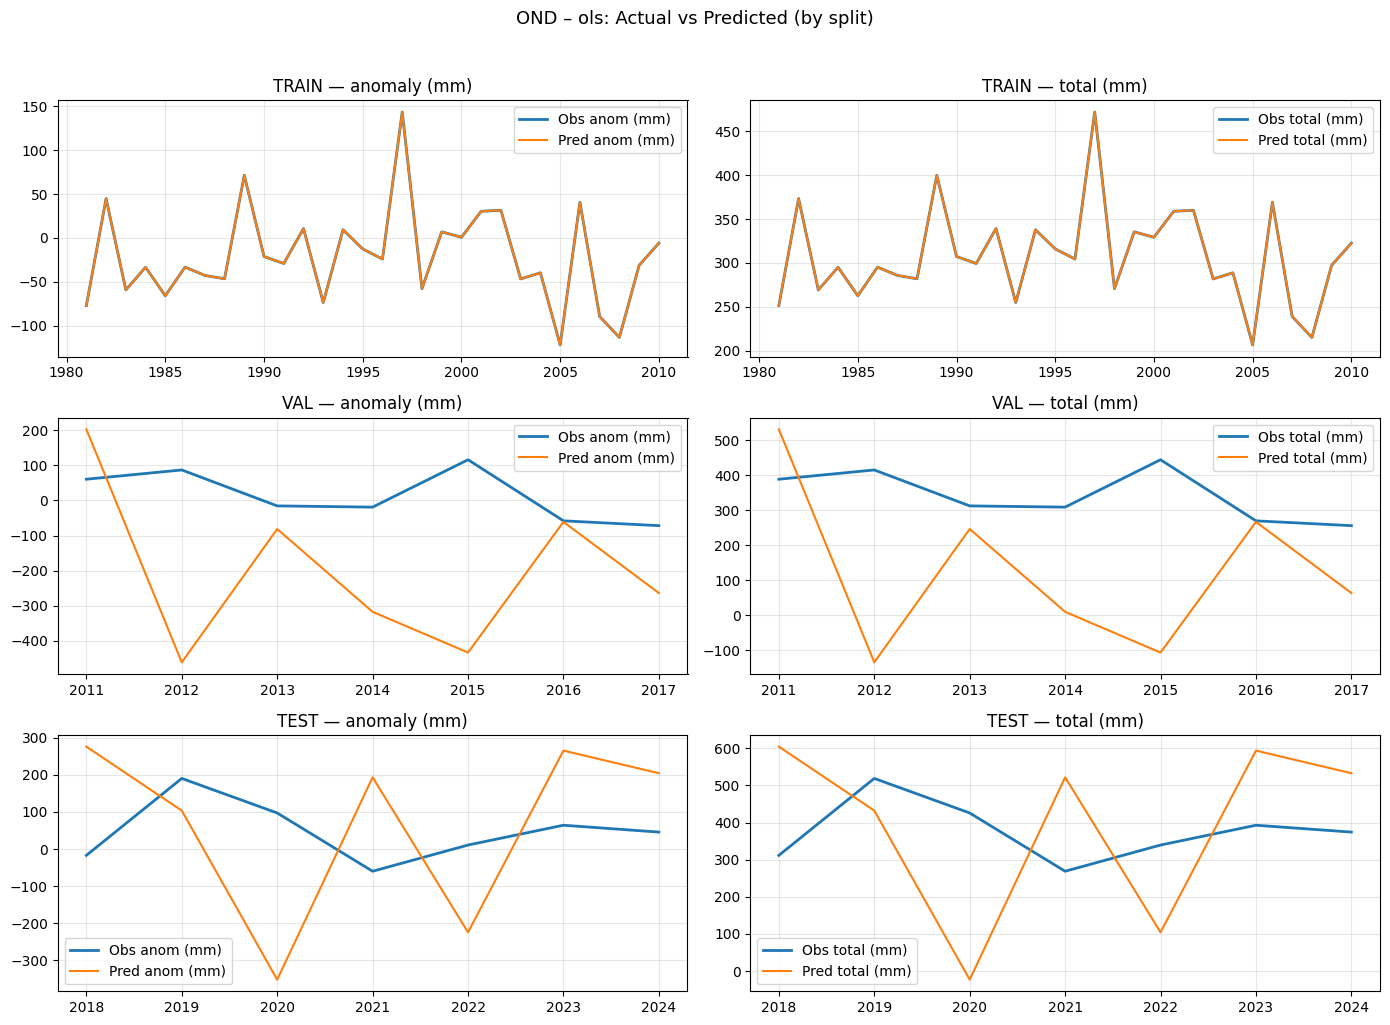

Saved reports/figures\OND_ols_pred_vs_obs_scatter.png


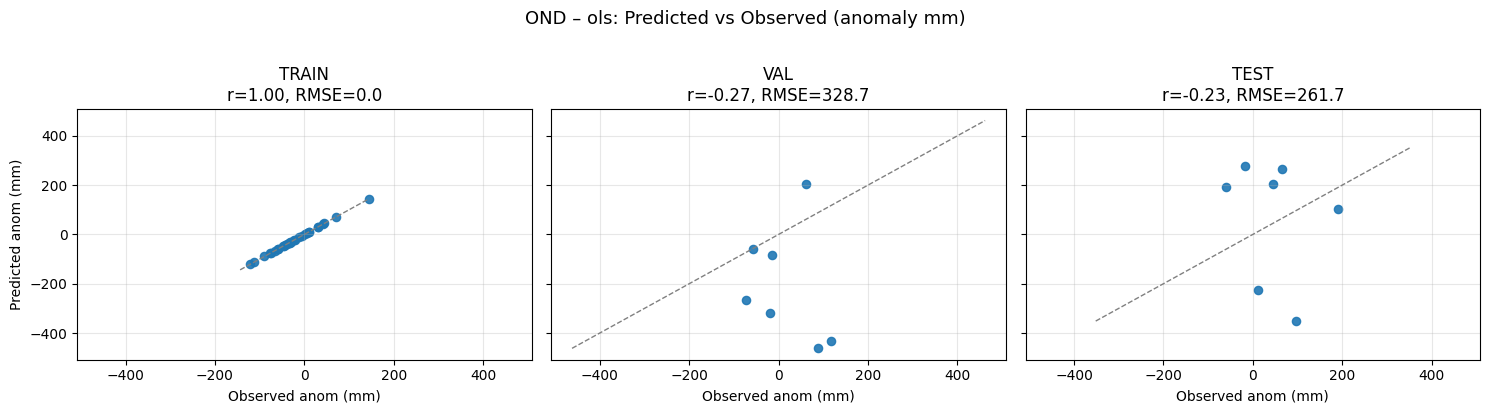

In [38]:
plot_actual_vs_pred_lines(OND_all_models, "OND", "ols")
plot_pred_vs_obs_scatter(OND_all_models, "OND", "ols")

## LASSO

Saved reports/figures\OND_lasso_actual_vs_pred_lines.png


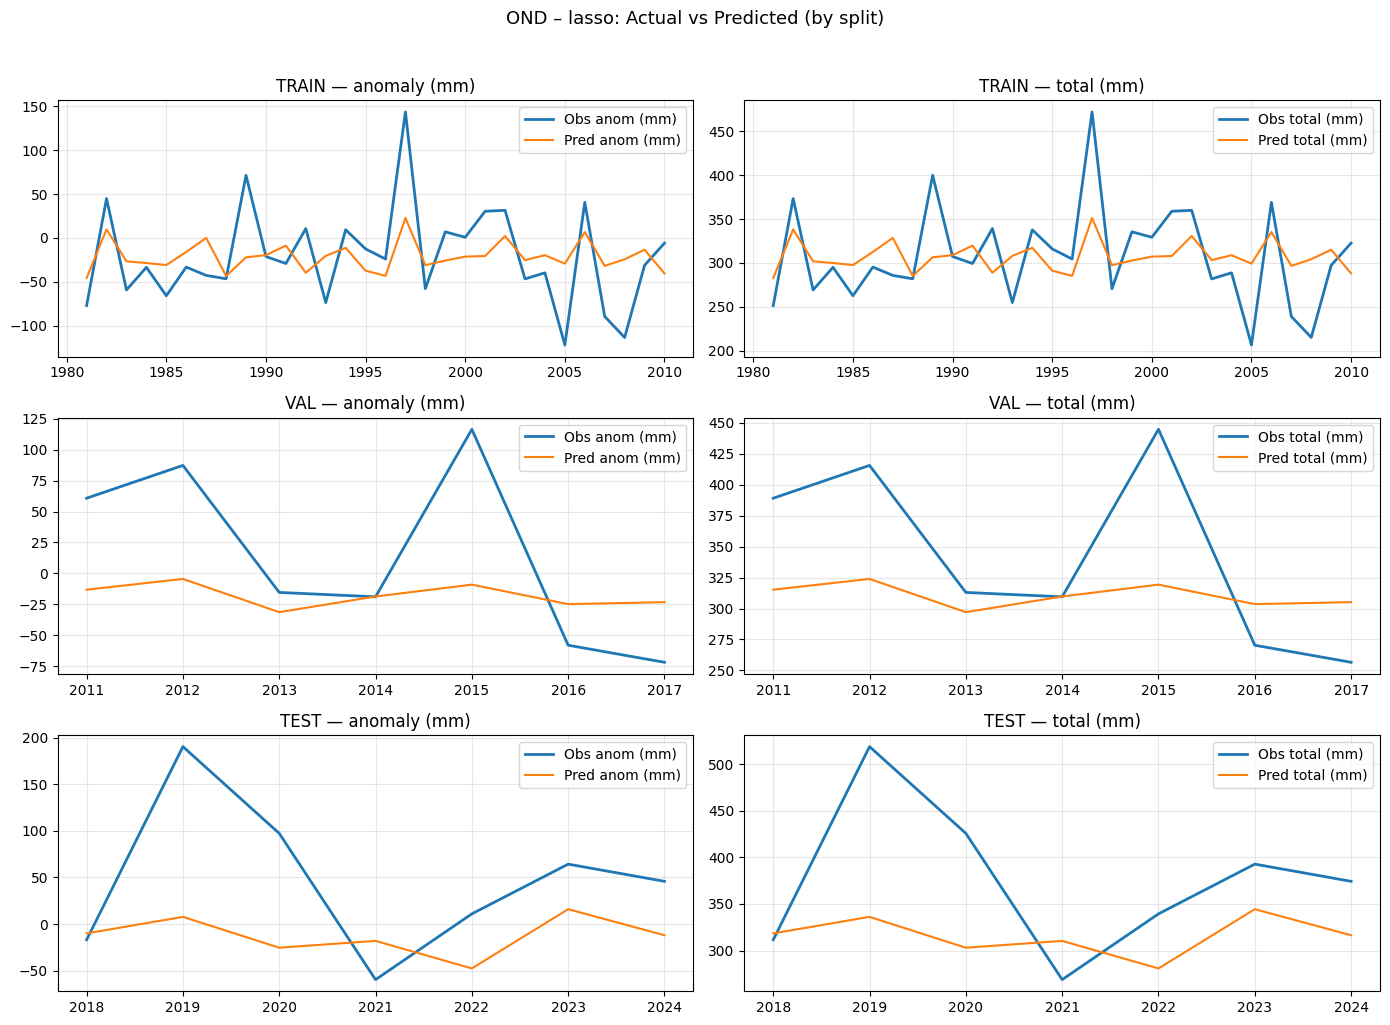

Saved reports/figures\OND_lasso_pred_vs_obs_scatter.png


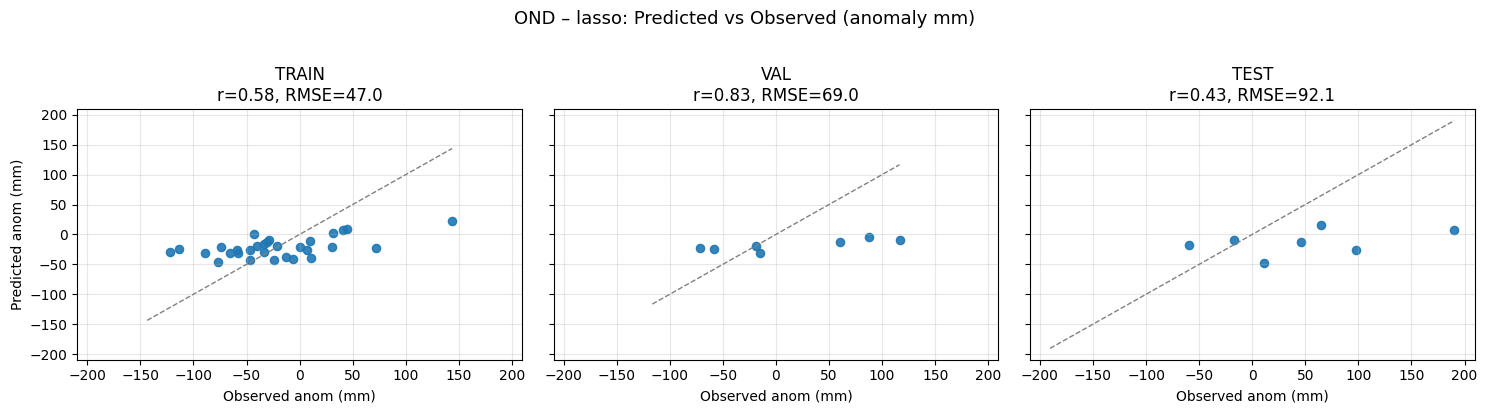

In [37]:
plot_actual_vs_pred_lines(OND_all_models, "OND", "lasso")
plot_pred_vs_obs_scatter(OND_all_models, "OND", "lasso")

In [2]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor

In [14]:
def make_model_and_grid(kind: str):
    if kind == "ols":
        pipe = Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
            ("mdl", LinearRegression())
        ])
        grid = {}
    elif kind == "ridge":
        pipe = Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
            ("mdl", Ridge(random_state=RANDOM_STATE, max_iter=10000))
        ])
        grid = {"mdl__alpha": np.logspace(-4, 2, 15)}
    elif kind == "lasso":
        pipe = Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
            ("mdl", Lasso(random_state=RANDOM_STATE, max_iter=20000))
        ])
        grid = {"mdl__alpha": np.logspace(-4, 1, 15)}
    elif kind == "enet":
        pipe = Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
            ("mdl", ElasticNet(random_state=RANDOM_STATE, max_iter=20000))
        ])
        grid = {"mdl__alpha": np.logspace(-4, 1, 12), "mdl__l1_ratio": [0.1,0.3,0.5,0.7,0.9]}

    # 🔽 NEW: Decision Tree
    elif kind == "dt":
        pipe = Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            # trees don't need scaling
            ("mdl", DecisionTreeRegressor(random_state=RANDOM_STATE))
        ])
        # Keep grids modest (dataset is small ~ 40-45 rows)
        grid = {
            "mdl__max_depth": [None, 2, 3, 4, 5, 6, 8],
            "mdl__min_samples_leaf": [1, 2, 3, 4, 5],
            "mdl__min_samples_split": [2, 3, 4, 5, 8, 10],
            "mdl__max_features": [None, "sqrt", 0.5, 0.7, 0.9],
        }

    # 🔽 NEW: Extra Trees (Extremely Randomized Trees)
    elif kind == "etr":
        pipe = Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("mdl", ExtraTreesRegressor(
                n_estimators=300,  # tuned via grid
                random_state=RANDOM_STATE,
                n_jobs=-1
            ))
        ])
        grid = {
            "mdl__n_estimators": [200, 300, 600],
            "mdl__max_depth": [None, 3, 5, 7, 9],
            "mdl__min_samples_leaf": [1, 2, 3, 4],
            "mdl__max_features": [None, "sqrt", 0.5, 0.7, 0.9],
            "mdl__bootstrap": [False],  # keep False for ExtraTrees (default)
        }
    else:
        raise ValueError("kind must be one of: 'ols','ridge','lasso','enet','dt','etr'")
    return pipe, grid


In [44]:
# --- after gscv.fit(...) in fixed_splits_eval ---
# Save feature importances for tree models (if available)
if hasattr(gscv.best_estimator_["mdl"], "feature_importances_"):
    fi = gscv.best_estimator_["mdl"].feature_importances_
    fi_df = pd.DataFrame({"feature": xcols, "importance": fi}).sort_values("importance", ascending=False)
    fi_out = os.path.join(PROCESSED_DIR, f"{season}_{kind}_feature_importance_TRAIN.csv")
    fi_df.to_csv(fi_out, index=False)


NameError: name 'gscv' is not defined

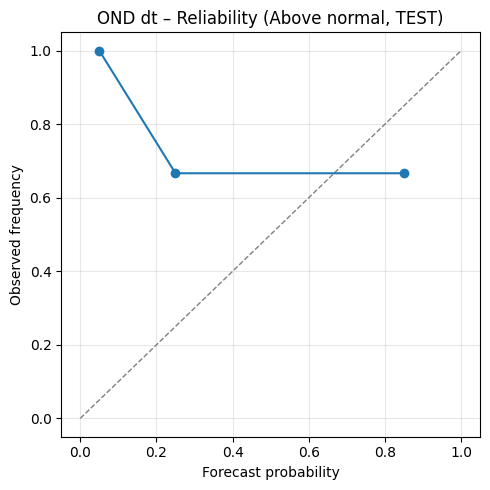

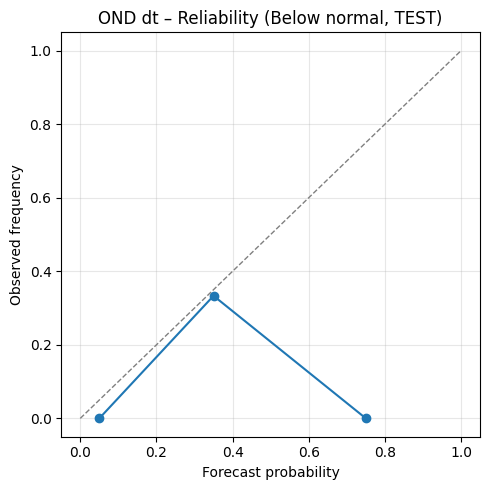

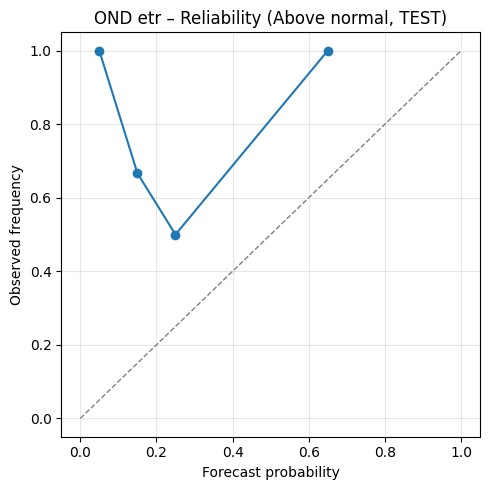

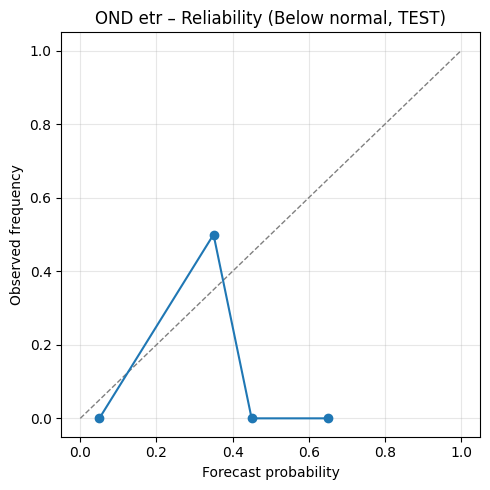

,tr_r,tr_MAE,tr_RMSE,tr_MSESS_vs_clim,tr_Bias,va_r,va_MAE,va_RMSE,va_MSESS_vs_clim,va_Bias,te_r,te_MAE,te_RMSE,te_MSESS_vs_clim,te_Bias,sigma_train,best_params
model,,,,,,,,,,,,,,,,,
dt,0.699535,29.679992,39.033475,0.555784,2.102022e-15,0.312199,54.889004,76.345292,-0.200412,-36.061098,0.366697,70.911446,80.553813,0.187909,-35.529870,39.700763,"{'mdl__max_depth': 2, 'mdl__max_features': 0.7..."
etr,0.824603,25.129560,35.272920,0.637254,-1.184238e-15,0.834176,53.410729,64.335964,0.147541,-37.274056,0.209038,76.941558,98.734576,-0.220032,-65.243104,35.875919,"{'mdl__bootstrap': False, 'mdl__max_depth': No..."


In [15]:
OND_fixed_trees = fixed_splits_eval(
    OND_tab, "OND", OND_X, "OND_anom_mm", "OND_clim1991_2020_mm",
    years=(1981, 2010, 2017, 2024),
    models=("dt","etr")
)

OND_fixed_trees


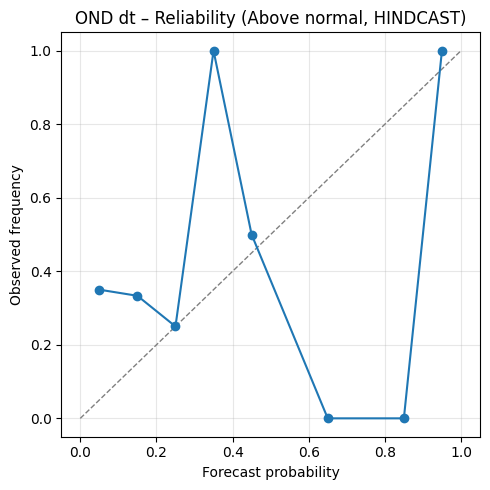

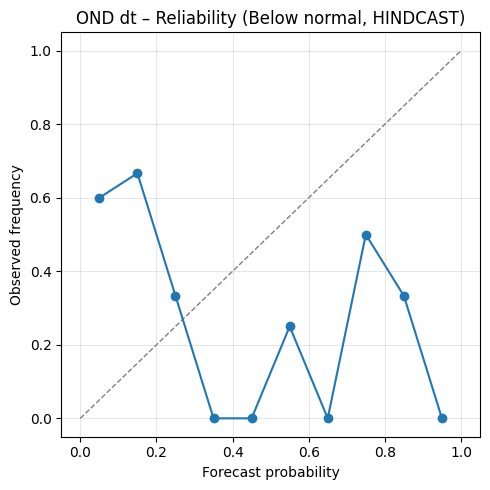

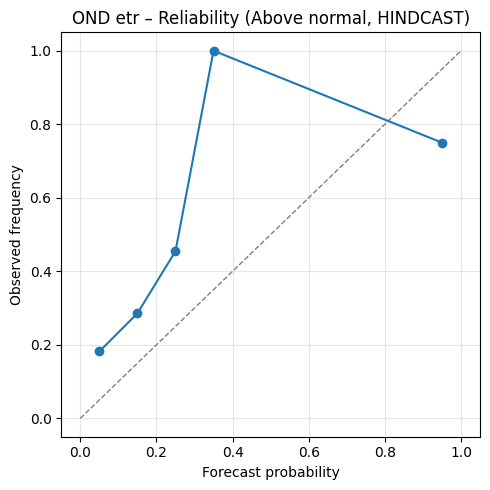

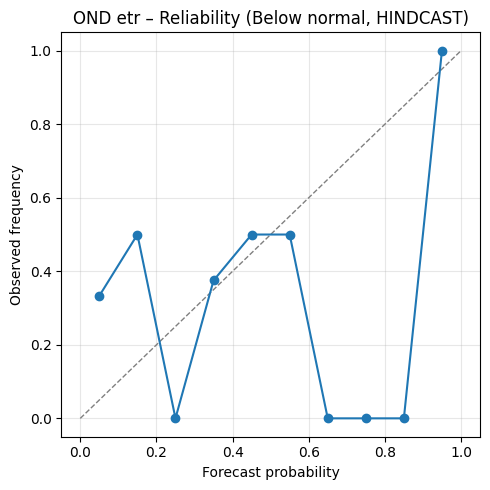

,r,MAE,RMSE,MSESS_vs_clim,Bias
model,,,,,
dt,0.169420,68.755847,82.704148,-0.407317,-32.129012
etr,0.312495,53.561331,68.913537,0.022883,-13.286361


In [19]:
OND_hc_trees, OND_hc_trees_summary = hindcast_regression(
    OND_tab, "OND", OND_X, "OND_anom_mm", "OND_clim1991_2020_mm",
    models=("dt","etr")
)

OND_hc_trees_summary


In [22]:
PROCESSED_DIR = "data/processed"

def load_split_preds(season: str, model: str):
    """
    Load TRAIN/VAL/TEST CSVs written by fixed_splits_eval(...) for a given season+model.
    Returns dict with keys 'TRAIN','VAL','TEST' -> DataFrames indexed by season_year.
    """
    out = {}
    for split in ("train","val","test"):
        path = os.path.join(PROCESSED_DIR, f"{season}_{model}_split_pred_{split}.csv")
        if not os.path.exists(path):
            raise FileNotFoundError(f"Missing file: {path}. Did you run fixed_splits_eval for {season}/{model}?")
        df = pd.read_csv(path, index_col=0)
        if not np.issubdtype(df.index.dtype, np.integer):
            df.index = pd.Index(df.index).astype(int)
        df.index.name = "season_year"
        df["model"] = model
        df["split"] = split.upper()
        out[split.upper()] = df
    return out

def combine_splits(preds_dict: dict) -> pd.DataFrame:
    """Concat TRAIN/VAL/TEST into one tidy table."""
    combo = pd.concat([preds_dict[k] for k in ("TRAIN","VAL","TEST")], axis=0)
    return combo.sort_index()

def load_all_models_for_season(season: str, models=("ols","ridge","lasso","enet","dt","etr")) -> pd.DataFrame:
    """Load and stack split predictions for several models of one season."""
    frames = []
    for m in models:
        try:
            frames.append(combine_splits(load_split_preds(season, m)))
        except FileNotFoundError as e:
            print(f"[skip] {season}/{m}: {e}")
    if not frames:
        raise RuntimeError(f"No split prediction files found for season={season} and models={models}.")
    all_df = pd.concat(frames, axis=0).sort_index()
    out_path = os.path.join(PROCESSED_DIR, f"{season}_ALLMODELS_actual_vs_pred_split_all.csv")
    all_df.to_csv(out_path)
    print("WROTE", out_path)
    return all_df


In [24]:
def _metrics_det_quick(y_true, y_pred):
    y_true = np.asarray(y_true, float); y_pred = np.asarray(y_pred, float)
    m = np.isfinite(y_true) & np.isfinite(y_pred)
    y_true, y_pred = y_true[m], y_pred[m]
    r = np.corrcoef(y_true, y_pred)[0,1] if y_true.size>1 and np.std(y_true)>0 and np.std(y_pred)>0 else np.nan
    rmse = float(np.sqrt(np.mean((y_true - y_pred)**2))) if y_true.size else np.nan
    return r, rmse

def plot_actual_vs_pred_lines(df: pd.DataFrame, season: str, model: str, save=True):
    fig, axes = plt.subplots(3, 2, figsize=(14, 10), sharex=False)
    splits = ["TRAIN","VAL","TEST"]
    for i, sp in enumerate(splits):
        g = df[(df["model"]==model) & (df["split"]==sp)].sort_index()
        if g.empty: 
            for j in (0,1): axes[i,j].set_axis_off()
            continue
        ax = axes[i,0]
        ax.plot(g.index, g["y_obs_anom_mm"], label="Obs anom (mm)", lw=2)
        ax.plot(g.index, g["y_pred_anom_mm"], label="Pred anom (mm)")
        ax.set_title(f"{sp} — anomaly (mm)"); ax.grid(alpha=0.3); ax.legend(loc="best")
        ax = axes[i,1]
        ax.plot(g.index, g["y_obs_total_mm"], label="Obs total (mm)", lw=2)
        ax.plot(g.index, g["y_pred_total_mm"], label="Pred total (mm)")
        ax.set_title(f"{sp} — total (mm)"); ax.grid(alpha=0.3); ax.legend(loc="best")
    fig.suptitle(f"{season} – {model}: Actual vs Predicted (by split)", y=1.02, fontsize=13)
    fig.tight_layout()
    if save:
        out = os.path.join(PROCESSED_DIR, f"{season}_{model}_actual_vs_pred_lines.png")
        fig.savefig(out, dpi=150); print("Saved", out)
    plt.show()

def plot_pred_vs_obs_scatter(df: pd.DataFrame, season: str, model: str, save=True):
    splits = ["TRAIN","VAL","TEST"]
    fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=True)
    for i, sp in enumerate(splits):
        ax = axes[i]
        g = df[(df["model"]==model) & (df["split"]==sp)]
        if g.empty: ax.set_axis_off(); continue
        x = g["y_obs_anom_mm"].values; y = g["y_pred_anom_mm"].values
        ax.scatter(x, y, s=35, alpha=0.9)
        lim = np.nanmax(np.abs(np.concatenate([x,y]))) if len(x)>0 else 1.0
        lim = max(1.0, lim)
        ax.plot([-lim, lim], [-lim, lim], "--", color="gray", lw=1)
        r, rmse = _metrics_det_quick(x, y)
        ax.set_title(f"{sp}\nr={r:.2f}, RMSE={rmse:.1f}")
        ax.set_xlabel("Observed anom (mm)")
        if i==0: ax.set_ylabel("Predicted anom (mm)")
        ax.grid(alpha=0.3)
    fig.suptitle(f"{season} – {model}: Predicted vs Observed (anomaly mm)", y=1.02, fontsize=13)
    fig.tight_layout()
    if save:
        out = os.path.join(PROCESSED_DIR, f"{season}_{model}_pred_vs_obs_scatter.png")
        fig.savefig(out, dpi=150); print("Saved", out)
    plt.show()


WROTE data/processed\OND_ALLMODELS_actual_vs_pred_split_all.csv
Saved data/processed\OND_etr_actual_vs_pred_lines.png


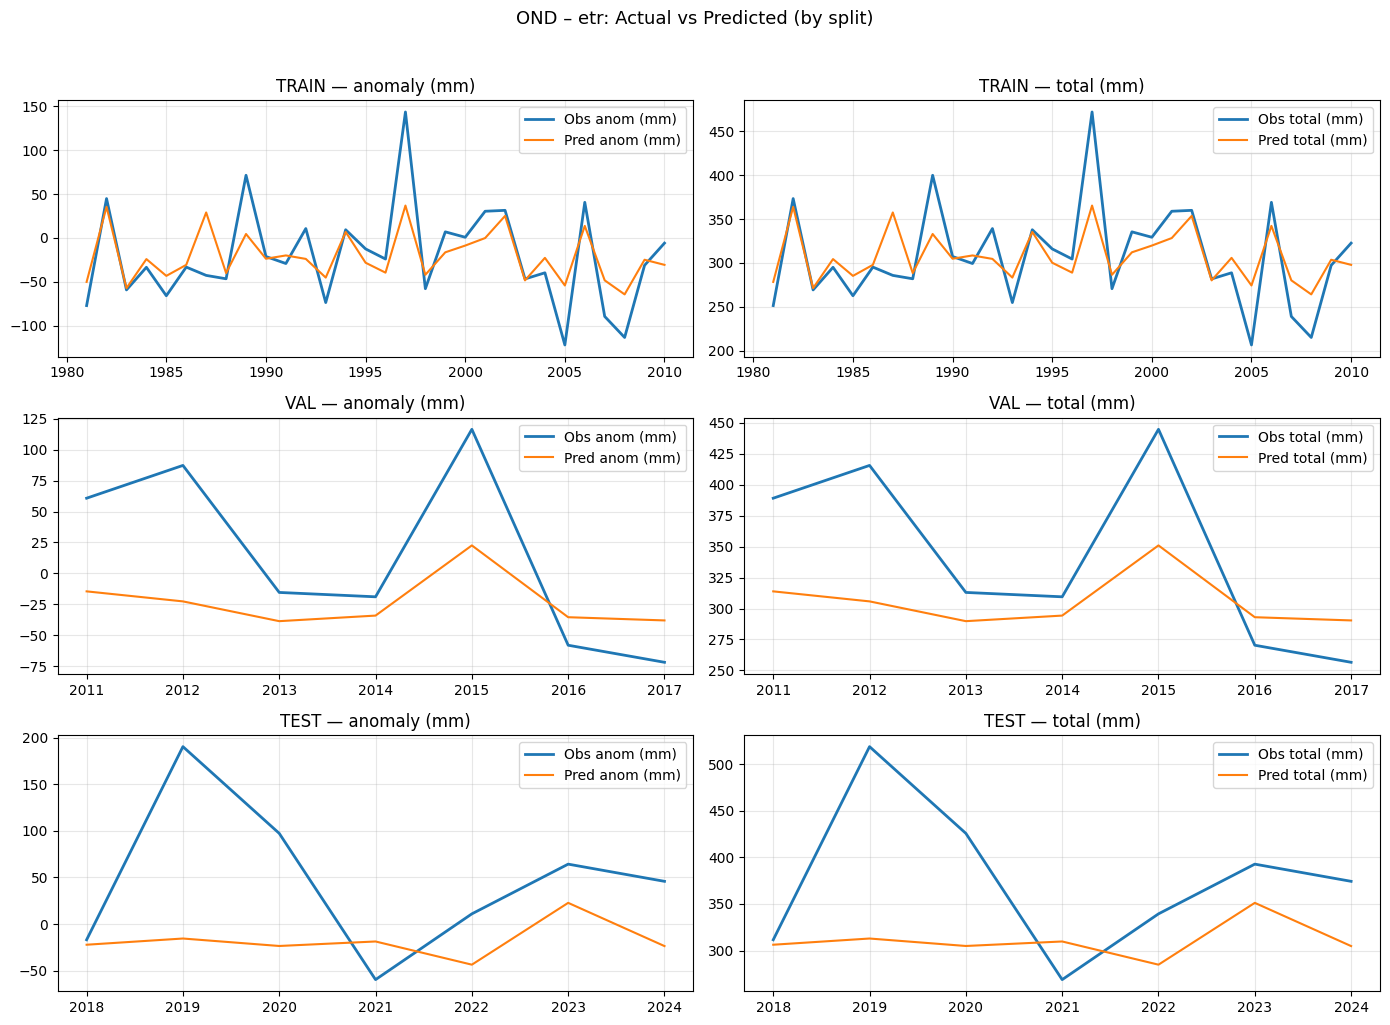

Saved data/processed\OND_etr_pred_vs_obs_scatter.png


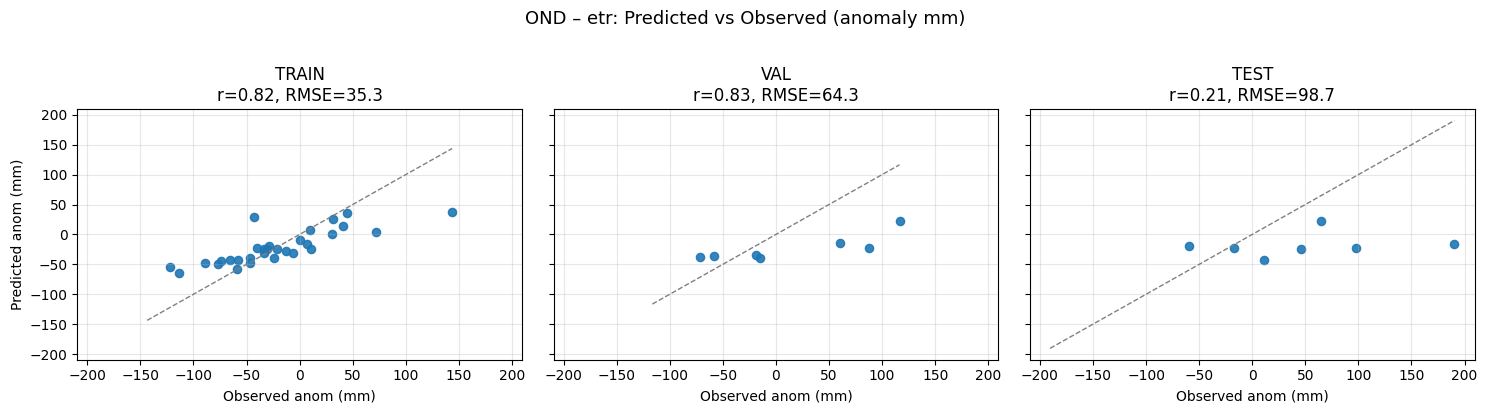

In [25]:
# If you used load_all_models_for_season earlier, you can append tree models too
OND_all_models_trees = load_all_models_for_season("OND", models=("dt","etr"))
plot_actual_vs_pred_lines(OND_all_models_trees, "OND", "etr")
plot_pred_vs_obs_scatter(OND_all_models_trees, "OND", "etr")


In [ ]:
PROCESSED_DIR = "data/processed"
os.makedirs(PROCESSED_DIR, exist_ok=True)

# --- helpers (safe to re-run) ---
def load_split_preds(season: str, model: str):
    out = {}
    for split in ("train","val","test"):
        path = os.path.join(PROCESSED_DIR, f"{season}_{model}_split_pred_{split}.csv")
        if not os.path.exists(path):
            raise FileNotFoundError(f"Missing file: {path}")
        df = pd.read_csv(path, index_col=0)
        if not np.issubdtype(df.index.dtype, np.integer):
            df.index = pd.Index(df.index).astype(int)
        df.index.name = "season_year"
        df["model"] = model
        df["split"] = split.upper()
        out[split.upper()] = df
    return out

def combine_splits(preds_dict: dict) -> pd.DataFrame:
    return pd.concat([preds_dict[k] for k in ("TRAIN","VAL","TEST")], axis=0).sort_index()

def load_all_models_for_season(season: str, models=None) -> pd.DataFrame:
    # Auto-detect models if not provided
    if models is None:
        files = glob.glob(os.path.join(PROCESSED_DIR, f"{season}_*_split_pred_train.csv"))
        models = sorted({os.path.basename(p).split("_")[1] for p in files})
        print(f"Detected models for {season}:", models)
    frames = []
    for m in models:
        try:
            frames.append(combine_splits(load_split_preds(season, m)))
        except FileNotFoundError as e:
            print(f"[skip] {season}/{m}: {e}")
    if not frames:
        raise RuntimeError(f"No split prediction files found for season={season}.")
    all_df = pd.concat(frames, axis=0).sort_index()
    out_path = os.path.join(PROCESSED_DIR, f"{season}_ALLMODELS_actual_vs_pred_split_all.csv")
    all_df.to_csv(out_path)
    print("WROTE", out_path)
    return all_df

# Deterministic metrics (robust to NaNs + older sklearn)
def _metrics_det(y_true, y_pred):
    y_true = np.asarray(y_true, float).ravel()
    y_pred = np.asarray(y_pred, float).ravel()
    m = np.isfinite(y_true) & np.isfinite(y_pred)
    y_true, y_pred = y_true[m], y_pred[m]
    if y_true.size == 0:
        return {"r": np.nan, "MAE": np.nan, "RMSE": np.nan,
                "MSESS_vs_clim": np.nan, "Bias": np.nan}
    r = float(np.corrcoef(y_true, y_pred)[0,1]) if (np.std(y_true)>0 and np.std(y_pred)>0) else np.nan
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)  # squared=True default
    rmse = float(np.sqrt(mse))
    mse_clim = mean_squared_error(y_true, np.zeros_like(y_true))
    msess = float(1 - (mse / mse_clim)) if mse_clim > 0 else np.nan
    bias = float(np.mean(y_pred - y_true))
    return {"r": r, "MAE": mae, "RMSE": rmse, "MSESS_vs_clim": msess, "Bias": bias}

def _metrics_total(y_true_total, y_pred_total):
    y_true = np.asarray(y_true_total, float).ravel()
    y_pred = np.asarray(y_pred_total, float).ravel()
    m = np.isfinite(y_true) & np.isfinite(y_pred)
    y_true, y_pred = y_true[m], y_pred[m]
    if y_true.size == 0:
        return {"r_total": np.nan, "MAE_total": np.nan, "RMSE_total": np.nan, "Bias_total": np.nan}
    r = float(np.corrcoef(y_true, y_pred)[0,1]) if (np.std(y_true)>0 and np.std(y_pred)>0) else np.nan
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    bias = float(np.mean(y_pred - y_true))
    return {"r_total": r, "MAE_total": mae, "RMSE_total": rmse, "Bias_total": bias}

def metrics_by_split(df: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for (model, split), g in df.groupby(["model","split"]):
        a = _metrics_det(g["y_obs_anom_mm"],  g["y_pred_anom_mm"])
        t = _metrics_total(g["y_obs_total_mm"], g["y_pred_total_mm"])
        rows.append({"model": model, "split": split, **a, **t})
    return pd.DataFrame(rows).sort_values(["model","split"]).reset_index(drop=True)




NameError: name 'glob' is not defined

In [36]:
# --- Build OND_all_models and compute metrics ---
OND_all_models = load_all_models_for_season("OND")  

Detected models for OND: ['dt', 'enet', 'etr', 'lasso', 'ols', 'ridge']
WROTE data/processed\OND_ALLMODELS_actual_vs_pred_split_all.csv


In [37]:

OND_split_scores = metrics_by_split(OND_all_models)
OND_split_scores.to_csv(os.path.join(PROCESSED_DIR, "OND_split_metrics_by_model.csv"), index=False)
OND_split_scores

,model,split,r,MAE,RMSE,MSESS_vs_clim,Bias,r_total,MAE_total,RMSE_total,Bias_total
0,dt,TEST,0.366697,7.091145e+01,8.055381e+01,0.187909,-3.552987e+01,0.366697,7.091145e+01,8.055381e+01,-3.552987e+01
1,dt,TRAIN,0.699535,2.967999e+01,3.903348e+01,0.555784,-4.440892e-16,0.699535,2.967999e+01,3.903348e+01,5.684342e-15
2,dt,VAL,0.312199,5.488900e+01,7.634529e+01,-0.200412,-3.606110e+01,0.312199,5.488900e+01,7.634529e+01,-3.606110e+01
3,enet,TEST,0.287542,7.875917e+01,1.013172e+02,-0.284691,-7.057590e+01,0.287542,7.875917e+01,1.013172e+02,-7.057590e+01
4,enet,TRAIN,0.474145,3.998338e+01,4.921026e+01,0.293958,3.789561e-15,0.474145,3.998338e+01,4.921026e+01,-1.515825e-14
5,enet,VAL,0.754151,5.481972e+01,6.798039e+01,0.048228,-3.453847e+01,0.754151,5.481972e+01,6.798039e+01,-3.453847e+01
6,etr,TEST,0.209038,7.694156e+01,9.873458e+01,-0.220032,-6.524310e+01,0.209038,7.694156e+01,9.873458e+01,-6.524310e+01
7,etr,TRAIN,0.824603,2.512956e+01,3.527292e+01,0.637254,-2.250052e-15,0.824603,2.512956e+01,3.527292e+01,-1.136868e-14
8,etr,VAL,0.834176,5.341073e+01,6.433596e+01,0.147541,-3.727406e+01,0.834176,5.341073e+01,6.433596e+01,-3.727406e+01
9,lasso,TEST,0.430264,7.409601e+01,9.206353e+01,-0.060737,-6.025199e+01,0.430264,7.409601e+01,9.206353e+01,-6.025199e+01


# Gradient Boosting (sklearn GBM), XGBoost, and LightGBM

In [ ]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor 
from sklearn.ensemble import GradientBoostingRegressor

In [40]:
print("XGBoost available:", XGBRegressor, "| LightGBM available:", LGBMRegressor)


XGBoost available: <class 'xgboost.sklearn.XGBRegressor'> | LightGBM available: <class 'lightgbm.sklearn.LGBMRegressor'>


## Extend make_model_and_grid with gbr, xgb, lgbm

In [44]:
def make_model_and_grid(kind: str):
    # --- existing cases (ols, ridge, lasso, enet, dt, etr) should already be here ---
    # (keep your previous code above; only the new blocks are shown below)

    if kind == "gbr":  # sklearn GradientBoostingRegressor
        pipe = Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("mdl", GradientBoostingRegressor(random_state=RANDOM_STATE))
        ])
        grid = {
            "mdl__n_estimators": [100, 300, 600],
            "mdl__learning_rate": [0.03, 0.05, 0.1],
            "mdl__max_depth": [2, 3, 4],
            "mdl__subsample": [0.6, 0.8, 1.0],
            "mdl__max_features": [None, "sqrt", 0.5],
        }
        return pipe, grid

    if kind == "xgb":
        if not XGBRegressor:
            raise ImportError("XGBoost not available. Run: pip install xgboost")
        pipe = Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("mdl", XGBRegressor(
                objective="reg:squarederror",
                eval_metric="rmse",
                n_jobs=-1,
                random_state=RANDOM_STATE,
                tree_method="hist"  # fast & stable
            ))
        ])
        grid = {
            "mdl__n_estimators": [200, 400, 800],
            "mdl__learning_rate": [0.03, 0.05, 0.1],
            "mdl__max_depth": [2, 3, 4],
            "mdl__subsample": [0.6, 0.8, 1.0],
            "mdl__colsample_bytree": [0.6, 0.8, 1.0],
            "mdl__min_child_weight": [1, 3, 5],
            # optional regularization (kept modest for small n):
            "mdl__reg_lambda": [1.0, 5.0, 10.0],
        }
        return pipe, grid

    if kind == "lgbm":
        if not LGBMRegressor:
            raise ImportError("LightGBM not available. Run: pip install lightgbm")
        pipe = Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("mdl", LGBMRegressor(
                objective="regression",
                metric="rmse",
                n_jobs=-1,
                random_state=RANDOM_STATE,
                force_col_wise=True  # safer default for small data
            ))
        ])
        grid = {
            "mdl__n_estimators": [200, 400, 800],
            "mdl__learning_rate": [0.03, 0.05, 0.1],
            "mdl__max_depth": [-1, 3, 5],       # -1 = no limit
            "mdl__num_leaves": [15, 31, 63],    # interacts with depth
            "mdl__subsample": [0.6, 0.8, 1.0],
            "mdl__colsample_bytree": [0.6, 0.8, 1.0],
            "mdl__min_child_samples": [5, 10, 20],
            "mdl__reg_lambda": [0.0, 5.0, 10.0],
        }
        return pipe, grid

    # fall-through to your previous cases:
    return _previous_make_model_and_grid(kind)  # <— if you split the function; else keep the rest above


In [46]:
HAS_XGB = XGBRegressor 
HAS_LGBM = LGBMRegressor

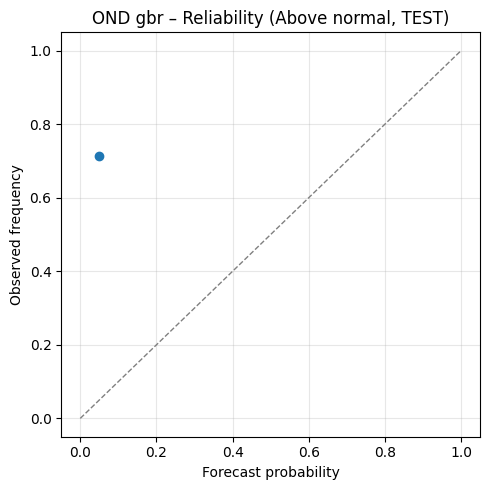

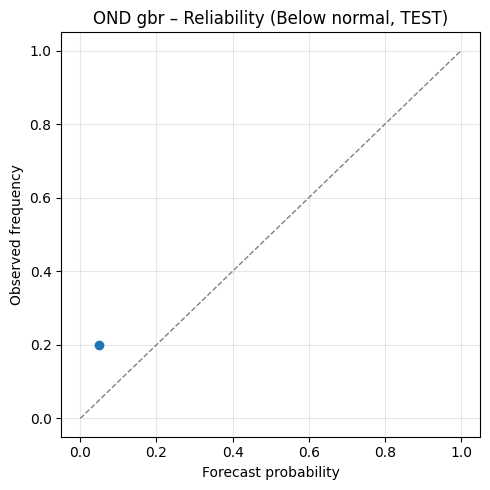

In [ ]:
# OND
OND_fixed_boost = fixed_splits_eval(
    OND_tab, "OND", OND_X, "OND_anom_mm", "OND_clim1991_2020_mm",
    years=(1981, 2010, 2017, 2024),
    models=tuple([m for m, ok in [("gbr", True), ("xgb", HAS_XGB), ("lgbm", HAS_LGBM)] if ok])
)
OND_fixed_boost

